### Préparation des données pour les modèles DIST_REL_CC, DIST_REL_CH et DIST_REL_OH et analyse de la distribution des longueurs de liaisons

### Intention

À la lumière des informations encourageantes extraites de l'analyse du modèle DIST_REL_C_01 (voir notebook 11.1), nous allons tenter de généraliser la méthode à plusieurs types de liaisons :

* carbone-hydrogène (modèle DIST_REL_CH)
* oxygène-hydrogène (modèle DIST_REL_OH)
* carbone-carbone (modèle DIST_REL_CC)

Le modèle DIST_REL_CC est donc identique au modèle DIST_REL_C_01, à la différence qu'on va l'entraîner sur plus d'exemples.


### Méthodologie

Nous allons de ce notebook générer les données d'entraînement pour chacun des modèles. Ces données auront les caractéristiques suivantes :

* Extraites de molécules ne contenant pas d'atome plus lourd que le fluor
* Extraites de molécules contenant entre 2 et 60 atomes
* Les données sur les molécules sont des données convergées

Chaque exemple du jeu de données correspondra aux informations concerant la longueur de la liaison entre deux atomes C-C, C-H ou O-H (en fonction du modèle associé au jeu de données).

* Données d'entrée :
    * Pour chaque exemple :
        * Pour chaque atome n'intervenant pas dans la liaison :
            * Le numéro atomique (encodé en one-hot-encoding)
            * La masse atomique
            * La classe positionnelle de l'atome par rapport à la liaison (voir notebook 9.1)
            * La distance à chacun des deux atomes de la liaison
            
            

* Données de sortie (cibles) :
    * Pour chaque exemple :
        * La distance entre les deux atomes de la liaison considérée
        

Une fois les jeux de données créés, nous entraîner un modèle par jeu de données, puis nous analyserons les prédictions de chacun des modèles sur des données de test que les modèles n'auront jamais vues (et que nous crééons également dans ce notebook).




#### Chemin des fichiers

In [3]:
# Données moléculaires d'origine
train_riken_reduced_loc = "../data/train_set_riken_v2_reduced.h5"
test_riken_reduced_loc = "../data/test_set_riken_v2_reduced.h5"
minimal_reduced_loc = "../data/minimal_set_riken_v2_reduced.h5"
complete_set = "../data/riken_v2.h5"

# Jeux préparés pour le modèle DIST_REL_CC
train_CC_prepared_input_loc = "../data/DIST_REL_CC/train_set_prepared_input.h5"
train_CC_labels_loc = "../data/DIST_REL_CC/train_set_labels.h5"
test_CC_prepared_input_loc = "../data/DIST_REL_CC/test_set_prepared_input.h5"
test_CC_labels_loc = "../data/DIST_REL_CC/test_set_labels.h5"
minimal_CC_prepared_input_loc = "../data/DIST_REL_CC/minimal_set_prepared_input(+ids).h5"
minimal_CC_labels_loc = "../data/DIST_REL_CC/minimal_set_labels(+ids).h5"

# Jeux préparés pour le modèle DIST_REL_CH
train_CH_prepared_input_loc = "../data/DIST_REL_CH/train_set_prepared_input.h5"
train_CH_labels_loc = "../data/DIST_REL_CH/train_set_labels.h5"
test_CH_prepared_input_loc = "../data/DIST_REL_CH/test_set_prepared_input.h5"
test_CH_labels_loc = "../data/DIST_REL_CH/test_set_labels.h5"

# Jeux préparés pour le modèle DIST_REL_OH
train_OH_prepared_input_loc = "../data/DIST_REL_OH/train_set_prepared_input.h5"
train_OH_labels_loc = "../data/DIST_REL_OH/train_set_labels.h5"
test_OH_prepared_input_loc = "../data/DIST_REL_OH/test_set_prepared_input.h5"
test_OH_labels_loc = "../data/DIST_REL_OH/test_set_labels.h5"

# Données de statistiques sur les distances entre les couples d'atomes considérés
stats_train_CH = "../data/stats/CH/CH_bonds_lengths_train_mol_size_2-60_elems_inf_Ne.h5"
stats_train_OH = "../data/stats/OH/OH_bonds_lengths_train_mol_size_2-60_elems_inf_Ne.h5"
stats_train_CC = "../data/stats/CC/CC_bonds_lengths_train_mol_size_2-60_elems_inf_Ne.h5"

stats_test_CH = "../data/stats/CH/CH_bonds_lengths_test_mol_size_2-60_elems_inf_Ne.h5"
stats_test_OH = "../data/stats/OH/OH_bonds_lengths_test_mol_size_2-60_elems_inf_Ne.h5"
stats_test_CC = "../data/stats/CC/CC_bonds_lengths_test_mol_size_2-60_elems_inf_Ne.h5"

stats_total_CH = "../data/stats/CH/CH_bonds_lengths_total_set.h5"
stats_total_OH = "../data/stats/OH/OH_bonds_lengths_total_set.h5"
stats_total_CC = "../data/stats/CC/CC_bonds_lengths_total_set.h5"


#### Constantes

On définit ici les constantes concernant les numéros atomiques des atomes que l'on considère, et concernant les distances en deçà desquelles on considère qu'un couple d'atome partage une liaison. Ces distances sont calculées de la façon suivante : moyenne de la taille de la liaison + quatre fois l'écart-type.

In [4]:
H_ANUM = 1.
C_ANUM = 6.
O_ANUM = 8.

DIST_MAX_CC = 1.6
DIST_MAX_CH = 1.35
DIST_MAX_OH = 1.25

BATCH_SIZE = 20000

#### Calcul de la distance entre deux atomes

In [5]:
import numpy as np

def calcul_distance(pt1, pt2):
    """ Renvoie la distance entre deux points représentés par leurs coordonnées (x, y, z) dans deux tableaux
    de forme (1, 3)"""
    return np.sqrt(np.sum(np.square(np.diff(np.array([pt1, pt2]), axis=0))))

#### Fonction de test si deux atomes partagent une liaison (en fonction de leurs positions et numéros atomiques)

In [6]:
def existe_liaison(pos1, anum1, pos2, anum2):
    
    return ((anum1==C_ANUM and anum2==C_ANUM and calcul_distance(pos1, pos2) <= DIST_MAX_CC) or
            (anum1==C_ANUM and anum2==H_ANUM and calcul_distance(pos1, pos2) <= DIST_MAX_CH) or
            (anum1==O_ANUM and anum2==H_ANUM and calcul_distance(pos1, pos2) <= DIST_MAX_OH))

#### Fonction renvoyant les distances d'un atome à deux autres atomes

In [7]:
def calcul_distances(pt1, pt_ref1, pt_ref2):
    return np.array([calcul_distance(pt1, pt_ref1), calcul_distance(pt1, pt_ref2)])

#### Fonction renvoyant la classe positionnelle d'un atome en fonction de sa position et des positions des deux atomes de référence. Renvoie le résultat sous forme de one-hot-encoding

In [8]:
def get_classe_pos(pt, pos_a1, pos_a2):
    
    # Initialisation du tableau de sortie
    classes_pos = np.zeros(shape=(3,))
    
    # Calcul du vecteur A1_A2
    vect = np.diff([pos_a1, pos_a2], axis=0)
    
    # Déclaration de la matrice contenant les coordonnées des trois points g, c et d
    gcd_pos = np.empty(shape=(3, 3))
    
    # Calcul du point c
    gcd_pos[1] = np.divide([np.sum([pos_a1, pos_a2], axis=0)], 2)

    # Calcul des points g et d
    gcd_pos[0] = gcd_pos[1] - vect
    gcd_pos[2] = gcd_pos[1] + vect
        
    # Calcul de la matrice des positions répétées du point
    pos = np.tile(pt, 3).reshape(3, 3)
    
    # Calcul des distances du point avec les points g, c et d
    dists = np.sqrt(np.sum(np.square(np.diff([gcd_pos, pos], axis=0)[0]), axis=1))
    
    # On renvoie le résultat encodé avec la méthode du one hot encoding
    classes_pos[np.argmin(dists)] = 1
    return classes_pos
    

#### Fonction renvoyant le numéro de l'atome encodé en one-hot encoding (pour les atomes des deux premières lignes du tableau périodique)

In [9]:
def get_anum_one_hot(z):
    
    if not 0 < z < 10:
        raise RuntimeError("Atomic number must be between 1 and 9")
    
    one_hot = np.zeros(shape=(9,))
    one_hot[int(z)-1] = 1
    return one_hot


#### Fonction renvoyant les données préparées pour le RN pour une molécule

In [10]:
def donnees_prep_RN_mol(coords_mol, anums_mol, amasses_mol, anum_1, anum_2, pubchem_id):
    """ Fonction préparant les données à fournir aux modèles pour une molécule. On prend en entrée les
        données décrivant la molécules (coordonnées, numéros atomiques et masses atomiques) ainsi que
        les deux numéros atomiques des atomes dont on veut prédire la longueur de la liaison.
        On itère ensuite sur tous les couples de ces deux numéros atomiques, puis pour ceux qui partagent
        une liaison, pour chaque atome de la molécule privée des deux atomes du couple on créé une entrée
        du modèle composée du numéro atomique de l'atome (one-hot), de la classe positionnelle de l'atome
        (one-hot), de la masse atomique de l'atome et des distances de l'atome aux deux atomes du couple
        considéré.
        Pour chaque couple, la cible du modèle est la distance entre les deux atomes du couple """
    
    taille_mol = len(coords_mol)
    
    inputs_RN = []
    pubchem_ids = []
    targets_RN = []
    
    if pubchem_id==53374730:
        print("53374730 found")
        
    if pubchem_id==62039612:
        print("62039612 found")
        
    if pubchem_id==5250958:
        print("5250958 found")
    
    if pubchem_id==59918640:
        print("59918640 found")
        
    if pubchem_id==29935400:
        print("29935400 found")
        
    if pubchem_id==15886996:
        print("15886996 found")
        
    if pubchem_id==60668230:
        print("60668230 found")
    
    
    # On itère sur tous les atomes de la molécule
    for i in range(taille_mol):

        # On sélectionne le premier atome du couple
        if anums_mol[i] == anum_1:

            # On parcourt tous les atomes suivants
            for j in range(i+1, taille_mol):

                # On sélectionne le second atome du couple s'il existe une liaison avec le premier
                if anums_mol[j] == anum_2 and existe_liaison(coords_mol[i], anum_1, coords_mol[j], anum_2):

                    # On calcule la distance entre les deux atomes du couple
                    dist_couple = calcul_distance(coords_mol[i], coords_mol[j])

                    # On initialise l'entrée du RN pour le couple courant
                    input_rn = np.empty(shape=(taille_mol-2, 15))

                    input_rn_idx = 0

                    # On itère sur tous les atomes de la molécule (en dehors des deux atomes du couple)
                    for k in range(taille_mol):
                        if k != i and k != j:

                            # On enregistre le numéro et la masse atomique de l'atome
                            input_rn[input_rn_idx][:9] = get_anum_one_hot(anums_mol[k])
                            input_rn[input_rn_idx][9] = amasses_mol[k]

                            # On enregistre les distances de l'atome aux deux atomes du couple
                            input_rn[input_rn_idx][10:12] = calcul_distances(coords_mol[k], coords_mol[i],
                                                                         coords_mol[j])

                            # On enregistre la classe positionnelle de l'atome par rapport aux deux atomes
                            # de carbone
                            input_rn[input_rn_idx][12:15] = get_classe_pos(coords_mol[k], coords_mol[i], 
                                                                        coords_mol[j])    

                            input_rn_idx += 1

                    # On aplatit l'entrée du RN
                    input_rn = np.array(input_rn)
                    input_rn = input_rn.reshape(-1,)

                    # On enregistre l'entrée et la cible du RN pour le couple courant
                    inputs_RN.append(input_rn)

                    # On enregistre la distance cible pour le couple d'atomes courant (en mÅ)
                    targets_RN.append(dist_couple*1000)   

                    # On enregistre l'id pubchem associé à la molécule dont on a extrait l'exemple
                    pubchem_ids.append(pubchem_id)
                    
    if pubchem_ids!=[]:
        
        if pubchem_id not in pubchem_ids:
            print("ERREUR")
            print(pubchem_ids)
            print(pubchem_id)
            
    if 53374730 in pubchem_ids or 53374730. in pubchem_ids :
        print("53374730 in output")
        
    if 62039612 in pubchem_ids or 62039612. in pubchem_ids :
        print("62039612 in output")
        
    if 5250958 in pubchem_ids or 5250958. in pubchem_ids :
        print("5250958 in output")
    
    if 59918640 in pubchem_ids or 59918640. in pubchem_ids :
        print("59918640 in output")
        
    if 29935400 in pubchem_ids or 29935400. in pubchem_ids :
        print("29935400 in output")
        
    if 15886996 in pubchem_ids or 15886996. in pubchem_ids :
        print("15886996 in output")
        
    if 60668230 in pubchem_ids or 60668230. in pubchem_ids :
        print("60668230 in output")
    
            
    return np.array(inputs_RN), np.array(targets_RN), np.array(pubchem_ids)
            
        


#### Définition de la fonction de création du jeu de données

In [21]:
import h5py
import time


def generer_donnees(original_dataset_loc, prepared_input_loc, labels_loc, anum1, anum2, nb_mol, batch_size):
    """ Génère les entrées préparées et les labels pour le jeu de données, pour les couples d'atomes
        possédant les numéros atomiques donnés, à partir des nb\_mol premières molécules du jeu.
        Enregistre en plus un fichier h5 contenant toutes les distances """
    
    start_time = time.time()
    
    # On charge les données du jeu original en mémoire
    original_dataset_h5 = h5py.File(original_dataset_loc, "r")
    
    # On créé les jeux de données d'entrée du RN et de labels
    input_rn_dataset_h5 = h5py.File(prepared_input_loc, 'w')
    labels_dataset_h5 = h5py.File(labels_loc, 'w')
    
    
    try:
        
        varlen_floatarray = h5py.special_dtype(vlen=np.dtype("float32"))
        
        input_dataset = input_rn_dataset_h5.create_dataset("inputs", maxshape=(None,), shape=(0,),
                                           dtype=varlen_floatarray, compression="gzip", 
                                           chunks=True)
        
        ids_dataset = input_rn_dataset_h5.create_dataset("pubchem_ids", maxshape=(None,), shape=(0,),
                                          dtype=np.int32, compression="gzip",
                                          chunks=True)
                                            

        target_dataset = labels_dataset_h5.create_dataset("targets", maxshape=(None,), shape=(0,),
                                           dtype=np.float32, compression="gzip", 
                                           chunks=True)
        
        x_min_batch = 0
        x_max_batch = batch_size
        dataset_curr_idx = 0
        
        nb_total_mol = len(np.array(original_dataset_h5["anums"]))
        datasets_curr_idx = 0
        
        while x_min_batch <= nb_total_mol:
            
            print("Nouveau batch (molécules de "+str(x_min_batch)+" à "+str(min(x_max_batch, nb_total_mol))+
                  ") --- "+str(float(min(x_min_batch, nb_total_mol)/nb_total_mol*100))+" %")
            
            
            # On charge en mémoire les coordonnées et les numéros atomiques des molécules du batch courant
            input_coords = np.array(original_dataset_h5["riken_coords"][:nb_mol][x_min_batch:x_max_batch])
            input_nums = np.array(original_dataset_h5["anums"][:nb_mol][x_min_batch:x_max_batch])
            input_masses = np.array(original_dataset_h5["amasses"][:nb_mol][x_min_batch:x_max_batch])
            input_ids = np.array(original_dataset_h5["pubchem_id"][:nb_mol][x_min_batch:x_max_batch])

            
            # On créé les tableaux pour le batch courant
            inputs_batch = []
            ids_batch = []
            outputs_batch = []
            
            # On parcourt toutes les molécules du batch courant
            for batch_idx in range(len(input_nums)):
                
                # On ne s'intéresse pas aux molécules contenenant des atomes plus lourds que le fluor (contrainte
                # imposée par l'utilisation d'un one-hot encoding pour les numéros atomiques)
                if max(input_nums[batch_idx])<10:
                    
                    # On calcule les entrées et sortie du RN pour la molécule courante (il peut y avoir plusieurs
                    # entrées et plusieurs sorties s'il existe plusieurs couples de liaisons considérées
                    # dans la molécule)
                    curr_inputs_np, curr_outputs_np, curr_ids_np = donnees_prep_RN_mol(input_coords[batch_idx].reshape(-1, 3), 
                                                                        input_nums[batch_idx],
                                                                        input_masses[batch_idx], anum1, anum2,
                                                                        input_ids[batch_idx])
                    
                    # On ajoute les entrées et sorties aux tableaux du batch courant
                    if len(curr_inputs_np)>0:
                        inputs_batch.extend(curr_inputs_np)
                        outputs_batch.extend(curr_outputs_np)
                        ids_batch.extend(curr_ids_np)
                        
                        if 59918640. in curr_ids_np or 59918640 in curr_ids_np:
                            print("Found for mol of id "+str(input_ids[batch_idx]))
                        
                    
            # Fin du batch
            
                
            # On redimensionne les datasets
            input_dataset.resize((input_dataset.shape[0]+len(inputs_batch),))
            target_dataset.resize((target_dataset.shape[0]+len(inputs_batch),))
            ids_dataset.resize((ids_dataset.shape[0]+len(inputs_batch),))
            
            for id in ids_batch:
                if id==59918640 or id==59918640.:
                    print("59918640 in ids_batch")
            
            for id in np.array(ids_batch):
                if id==59918640 or id==59918640.:
                    print("59918640 in np ids_batch")
                    
            # On écrit les données dans les datasets
            input_dataset[datasets_curr_idx:datasets_curr_idx+len(inputs_batch)] = np.array(inputs_batch)
            target_dataset[datasets_curr_idx:datasets_curr_idx+len(inputs_batch)] = np.array(outputs_batch)
            ids_dataset[datasets_curr_idx:datasets_curr_idx+len(inputs_batch)] = np.array(ids_batch)
            
            
            print(np.array(ids_dataset[datasets_curr_idx:datasets_curr_idx+len(inputs_batch)]))
            print(np.array(ids_batch))

            if np.array_equal(np.array(ids_dataset[datasets_curr_idx:datasets_curr_idx+len(inputs_batch)]),
                              np.array(ids_batch)):
                print("Tableaux identiques")
            else:
                print("Tableaux différents")
            
            
            for id in np.array(ids_dataset[datasets_curr_idx:datasets_curr_idx+len(inputs_batch)]):
                if id==59918640:
                    print("59918640 written on disk")
            
            datasets_curr_idx += len(inputs_batch)
            x_min_batch += batch_size
            x_max_batch += batch_size
        
            
        input_rn_dataset_h5.flush()
        labels_dataset_h5.flush()
        
        ids = np.array(input_rn_dataset_h5["pubchem_ids"])
        
        """  for i, identifiant in enumerate(ids): 
            if identifiant==59918640. or identifiant==59918640:
                print(input_rn_dataset_h5["inputs"][i])"""
        
        print(str(len(input_dataset))+" exemples créés")
        print("--- %s seconds ---" % (time.time() - start_time))
            
            
    finally:
        input_rn_dataset_h5.close()
        labels_dataset_h5.close()
        original_dataset_h5.close()


### Recherche du nombre de molécules à partir desquelles on va extraire les données pour chaque couple d'atomes

Les différents couples (CC, CH, OH) étant plus ou moins représentés dans les données, nous allons rechercher le nombre de molécules à partir desquelles nous allons extraire les données pour chaque classe.

Nous souhaitons obtenir pour chaque classe un jeu d'entraînement contenant environ 4 millions d'exemples et un jeu de test contenant environ 800 000 exemples.

Nous allons pour cela chercher le nombre d'exemples que l'on obtient lorsqu'on applique l'algorithme de création des jeux de données aux 5000 premières molécules du jeu minimal, puis déterminer le nombre de molécules à partir desquelles on va extraire les exemples pour chaque jeu (test, entraînement) et chaque couple par calculs de proportions, sachant que l'on sait qu'on obtient 2 millions d'exemples pour CC lorsqu'on extrait les données des 400 000 premières molécules.

On suppose donc dans ces calculs que le jeu de données est homogène.

#### Modèle DIST_REL_CC

In [14]:
"""generer_donnees(minimal_reduced_loc, train_CC_prepared_input_loc, train_CC_labels_loc, C_ANUM, C_ANUM,
                5000, 1000)"""

'generer_donnees(minimal_reduced_loc, train_CC_prepared_input_loc, train_CC_labels_loc, C_ANUM, C_ANUM,\n                5000, 1000)'

Jeu d'entraînement : 800 000 molécules

Jeu de test : 160 000 molécules

#### Modèle DIST_REL_OH

In [24]:
"""generer_donnees(minimal_reduced_loc, train_OH_prepared_input_loc, train_OH_labels_loc, O_ANUM, H_ANUM,
                5000, 1000)"""

Molécule courante : 0 (0.0 %)
Molécule courante : 1000 (20.0 %)
Molécule courante : 2000 (40.0 %)
Molécule courante : 3000 (60.0 %)
Molécule courante : 4000 (80.0 %)
Molécule courante : 4999 (99.98 %)
1942 exemples créés
--- 6.448113441467285 seconds ---


Jeu d'entraînement : 16 000 000 molécules (nous ne disposons pas de tant de données, nous aurons donc moins d'exemples, environ 750 000)

Jeu de test : 3 200 000 molécules

#### Modèle DIST_REL_CH

In [17]:
"""generer_donnees(minimal_reduced_loc, train_CH_prepared_input_loc, train_CH_labels_loc, C_ANUM, H_ANUM,
                5000, 1000)"""

Nouveau batch (molécules de 0 à 1000) --- 1.0 %


KeyboardInterrupt: 

Jeu d'entraînement : 533 000 molécules

Jeu de test : 106 000 molécules

### Génération des données

#### Modèle DIST_REL_CC

In [ ]:
"""print("Génération jeu de test pour DIST_REL_CC")
generer_donnees(test_riken_reduced_loc, test_CC_prepared_input_loc, test_CC_labels_loc, C_ANUM, C_ANUM,
                160000, BATCH_SIZE)"""

##### Sortie

    1106823 exemples créés
    --- 6337.963872671127 seconds ---


In [ ]:
"""print("Génération jeu d'entraînement pour DIST_REL_CC")
generer_donnees(train_riken_reduced_loc, train_CC_prepared_input_loc, train_CC_labels_loc, C_ANUM, C_ANUM,
                800000, BATCH_SIZE)"""

##### Sortie

Information perdue, environ 5 millions d'exemples créés

In [22]:
"""print("Génération du jeu minimal pour DIST_REL_CC")
generer_donnees(minimal_reduced_loc, minimal_CC_prepared_input_loc, minimal_CC_labels_loc, C_ANUM, C_ANUM,
                100000, BATCH_SIZE)"""

Génération du jeu minimal pour DIST_REL_CC
Nouveau batch (molécules de 0 à 20000) --- 0.0 %
Nouveau batch (molécules de 20000 à 40000) --- 20.0 %


KeyboardInterrupt: 

#### Modèle DIST_REL_OH

In [ ]:
print("Génération jeu de test pour DIST_REL_OH")
generer_donnees(test_riken_reduced_loc, test_OH_prepared_input_loc, test_OH_labels_loc, O_ANUM, H_ANUM,
                3200000, BATCH_SIZE)

##### Sortie

    143588 exemples créés
    --- 973.4841437339783 seconds ---

In [ ]:
"""print("Génération jeu d'entraînement pour DIST_REL_OH")
generer_donnees(train_riken_reduced_loc, train_OH_prepared_input_loc, train_OH_labels_loc, O_ANUM, H_ANUM,
                16000000, BATCH_SIZE)"""

##### Sortie

    1293551 exemples créés
    --- 9165.71451497078 seconds ---


#### Modèle DIST_REL_CH

In [ ]:
"""print("Génération jeu de test pour DIST_REL_CH")
generer_donnees(test_riken_reduced_loc, test_CH_prepared_input_loc, test_CH_labels_loc, C_ANUM, H_ANUM,
                106000, BATCH_SIZE)"""

##### Sortie

    1158251 exemples créés
    --- 7187.15914607048 seconds ---


In [ ]:
"""print("Génération jeu d'entraînement pour DIST_REL_CH")
generer_donnees(train_riken_reduced_loc, train_CH_prepared_input_loc, train_CH_labels_loc, C_ANUM, H_ANUM,
                333000, BATCH_SIZE)"""

##### Sortie
    3636608 exemples créés
    --- 22205.555314302444 seconds ---

## Analyse de la distribution des distances dans les jeux de données

Afin de pouvoir analyser la distribution des longueurs de liaisons dans notre jeu de données, nous allons extraire ces distances des différents jeux de données. Pour chaque type de liaison (CC, CH, OH) et pour chaque jeu de données (jeu complet, jeu d'entraînement et jeu de test), nous allons enregistrer la distance de chaque exemple du jeu considéré dans un fichier h5.

#### Calcul de la distance entre deux atomes

In [19]:
import numpy as np

def calcul_distance(pt1, pt2):
    """ Renvoie la distance entre deux points représentés par leurs coordonnées (x, y, z) dans deux tableaux
    de forme (1, 3)"""
    return np.sqrt(np.sum(np.square(np.diff(np.array([pt1, pt2]), axis=0))))

#### Calcul des distances entre les couples d'atomes d'une molécule

In [20]:
def distances_mol(coords_mol, anums_mol, anum_1, anum_2):
    """ Renvoie un tableau contenant toutes les distances entre les couples d'éléments passés en paramètres """
    
    taille_mol = len(coords_mol)
    
    dists = []
    
    # On itère sur tous les atomes de la molécule
    for i in range(taille_mol):
        
        # On sélectionne le premier atome du couple
        if anums_mol[i] == anum_1:
            
            # On parcourt tous les atomes suivants
            for j in range(i+1, taille_mol):
                
                # On sélectionne le second atome du couple
                if anums_mol[j] == anum_2:
                    
                    # On calcule la distance entre les deux atomes du couple
                    dists.append(calcul_distance(coords_mol[i], coords_mol[j]))
                    
                    
    return np.array(dists)
            

#### Fonction de création du jeu de données de statistiques

In [21]:
def record_bonds_lengths(dataset_loc, output_lengths_loc, n_mols, anum_1, anum_2, batch_size,
                         only_below_Ne=True):
    """ Parcourt le jeu de données donné en entrée et enregistre dans un fichier h5 la longueur des liaisons
        dans les n_mols premières molécules entre les atomes de numéros atomiques anum_1 et anum_2 qui
        partagent une liaison.
        Si only_below_Ne est vrai, on ne calcule les distances que dans les molécules ne contenant pas d'atome
        plus lourd que le fluor (comme dans les jeux qui ont été utlisés pour l'entraînement des modèles) """
    
    start_time = time.time()    
    
    # On charge les données du jeu de données en mémoire
    original_dataset_h5 = h5py.File(dataset_loc, "r")    
    
    # On créé le jeu de données contenant les distances
    distances_h5 = h5py.File(output_lengths_loc, 'w')
    
    # On calcule le nombre total de molécules
    total_mol_nb = len(np.array(original_dataset_h5["anums"]))
    
    try:
        
        # Création du dataset de sortie (de taille nulle pour le moment)
        distances_dataset = distances_h5.create_dataset("distances", maxshape=(None,), shape=(0,),
                                           dtype=np.float32, compression="gzip", 
                                           chunks=True)
            
        # On initialise les bornes du premier batch de traitement et l'indice des données de sortie
        x_min_batch = 0
        x_max_batch = batch_size
        dataset_curr_idx = 0
        
        # On initialise le compteur de distances calculées
        nb_dist_tot = 0
                       
        # On calcule les distances sur chacun des batchs
        while x_min_batch < total_mol_nb:
            
            print("Nouveau batch (molécules de "+str(x_min_batch)+" à "+str(min(x_max_batch, total_mol_nb))+
                  ") --- "+str(float(min(x_max_batch, total_mol_nb)/total_mol_nb*100))+" %")
            
            # On charge en mémoire les coordonnées et les numéros atomiques des molécules du batch courant
            input_coords = np.array(original_dataset_h5["riken_coords"][x_min_batch:x_max_batch])
            input_nums = np.array(original_dataset_h5["anums"][x_min_batch:x_max_batch])
            
            # On créé le tableau python des distances pour le batch courant
            distances_batch = []
            
            # On parcourt toutes les molécules du batch
            for batch_idx in range(len(input_nums)):
                
                # Si l'option only_below_Ne est à vrai, on ignore les données provenant des molécules contenant
                # des atomes plus lourd que le fluor (comme dans certains jeu de données d'entraînement)
                if len(input_nums[batch_idx])>0 and (max(input_nums[batch_idx])<10 or not only_below_Ne):
                    
                    # On calcule les distances de la molécule
                    distances_batch.extend(distances_mol(input_coords[batch_idx].reshape(-1, 3), 
                                                         input_nums[batch_idx], anum_1, anum_2))
                if len(input_nums) == 0:
                    print("Pas d'atomes dans la molécule")
                
            # On enregistre les données du batch
            distances_dataset.resize((distances_dataset.shape[0]+len(distances_batch),))  # redimensionnement
            distances_dataset[dataset_curr_idx:dataset_curr_idx+len(distances_batch)] = np.array(distances_batch)
            
            # On met à jour les indexs courants dans les données d'entrée et de sortie
            dataset_curr_idx += len(distances_batch)
            x_min_batch += batch_size
            x_max_batch += batch_size
                       
            # On met à jour le nombre total de distances calculées
            nb_dist_tot += len(distances_batch)
                       
            print("... "+str(len(distances_batch))+" distances calculées")
                
        distances_h5.flush()
        
        print(str(nb_dist_tot)+" distances calculées au total")
        print("--- %s seconds ---" % (time.time() - start_time))
                
    
    finally:
        original_dataset_h5.close()
        distances_h5.close()

#### Calcul des distances CC sur le jeu minimal (test d'exécution)

In [24]:
"""print("Calcul distances jeu minimal")
record_bonds_lengths(minimal_reduced_loc, "../data/stats/CC/CC_bonds_lengths_minimal.h5", 100000, C_ANUM,
                     C_ANUM, 10000)"""

Calcul distances jeu minimal
Nouveau batch (molécules de 0 à 10000) --- 10.0 %
... 427095 distances calculées
Nouveau batch (molécules de 10000 à 20000) --- 20.0 %
... 424644 distances calculées
Nouveau batch (molécules de 20000 à 30000) --- 30.0 %
... 427189 distances calculées
Nouveau batch (molécules de 30000 à 40000) --- 40.0 %
... 425113 distances calculées
Nouveau batch (molécules de 40000 à 50000) --- 50.0 %
... 429110 distances calculées
Nouveau batch (molécules de 50000 à 60000) --- 60.0 %
... 426090 distances calculées
Nouveau batch (molécules de 60000 à 70000) --- 70.0 %
... 426353 distances calculées
Nouveau batch (molécules de 70000 à 80000) --- 80.0 %
... 424433 distances calculées
Nouveau batch (molécules de 80000 à 90000) --- 90.0 %
... 417634 distances calculées
Nouveau batch (molécules de 90000 à 100000) --- 100.0 %
... 425982 distances calculées
4253643 distances calculées au total
--- 83.4628496170044 seconds ---


### Enregistrement distances CC

Pour le jeu de test et d'entraînement, on ne s'intéresse qu'aux distances dans les molécules de taille comprise entre 2 et 60 et ne comportant pas d'atome plus lourd que le fluor.

Dans le jeu complet, on s'intéresse à toutes les molécules, y compris celles qui n'ont pas été intégrées dans le jeu réduit (voir notebook 8.0)

In [ ]:
"""print("Calcul distances CC sur le jeu de test...")
record_bonds_lengths(test_riken_reduced_loc, stats_test_CC, 160000, C_ANUM, C_ANUM, 100000)

print("Calcul distances CC sur le jeu d'entraînement...")
record_bonds_lengths(train_riken_reduced_loc, stats_train_CC, 800000, C_ANUM, C_ANUM, 100000)

print("Calcul distances CC dans le jeu complet...")
record_bonds_lengths(complete_set, stats_total_CC, 1000000000, C_ANUM, C_ANUM, 100000, only_below_Ne=False)"""

### Enregistrement distances CH

Pour le jeu de test et d'entraînement, on ne s'intéresse qu'aux distances dans les molécules de taille comprise entre 2 et 60 et ne comportant pas d'atome plus lourd que le fluor.

Dans le jeu complet, on s'intéresse à toutes les molécules, y compris celles qui n'ont pas été intégrées dans le jeu réduit (voir notebook 8.0)

In [ ]:
"""print("Calcul distances CH sur le jeu de test...")
record_bonds_lengths(test_riken_reduced_loc, stats_test_CH, 106000, C_ANUM, H_ANUM, 100000)

print("Calcul distances CH sur le jeu d'entraînement...")
record_bonds_lengths(train_riken_reduced_loc, stats_train_CH, 333000, C_ANUM, H_ANUM, 100000)

print("Calcul distances CH dans le jeu complet...")
record_bonds_lengths(complete_set, stats_total_CH, 1000000000, C_ANUM, H_ANUM, 100000, only_below_Ne=False)"""

### Enregistrement distances OH

Pour le jeu de test et d'entraînement, on ne s'intéresse qu'aux distances dans les molécules de taille comprise entre 2 et 60 et ne comportant pas d'atome plus lourd que le fluor.

Dans le jeu complet, on s'intéresse à toutes les molécules, y compris celles qui n'ont pas été intégrées dans le jeu réduit (voir notebook 8.0)

In [ ]:
"""print("Calcul distances OH sur le jeu de test...")
record_bonds_lengths(test_riken_reduced_loc, stats_test_OH, 3200000, O_ANUM, H_ANUM, 100000)

print("Calcul distances OH sur le jeu d'entraînement...")
record_bonds_lengths(train_riken_reduced_loc, stats_train_OH, 16000000, O_ANUM, H_ANUM, 100000)

print("Calcul distances OH dans le jeu complet...")
record_bonds_lengths(complete_set, stats_total_OH, 1000000000, O_ANUM, H_ANUM, 100000, only_below_Ne=False)"""

## Représentations graphiques des distributions des distances

#### Fonction de plot de la distribution des distances

In [4]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import h5py
import numpy as np

mpl.rcParams['agg.path.chunksize'] = 10000

def plot_distrib_dist(dists_file, padding,at1_name, at2_name, dataset_name, figures_loc, figure_name):
    """ Affiche la distribution des distances selon un pas donné """
    
    dists_h5 = h5py.File(dists_file, 'r')
    dists = np.array(dists_h5["distances"])
    
    # On calcule les bornes de notre index
    debut_index = np.floor(min(dists))
    fin_index = max(dists)+padding
    
    # On créé l'index
    index = np.arange(debut_index, fin_index, padding)
    
    # On créé le compteur d'occurences
    dists_occ = np.zeros_like(index)
        
    # Calcul des occurences
    for dist in dists:
        dists_occ[int((dist-debut_index)/padding)] += 1
        
    
    plt.xlabel("Distances "+at1_name+at2_name+" (en Å, par tranches de "+str(padding)+" )")
    plt.ylabel("Nombre d'occurences dans les données")
    plt.title("Distribution des distances "+at1_name+at2_name+"\ndans le jeu "+dataset_name)
    plt.plot(index, dists_occ)
    plt.show()
    plt.savefig(figures_loc+figure_name+".png", dpi=250)


In [5]:
figures_loc = "../figures/12.0-"

## Distances CC

### Jeu minimal

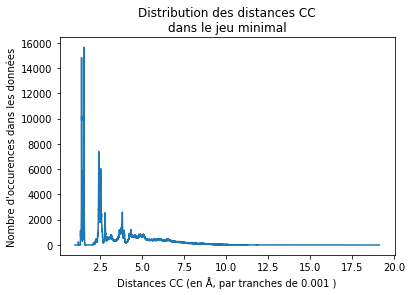

In [25]:
"""plot_distrib_dist("../data/stats/CC/CC_bonds_lengths_minimal.h5", 0.001, "C", "C", "minimal", figures_loc,
                  "distrib_CC_minimal")"""

False